In [291]:
# Import all the necessary libraries for data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import re
import datetime
# plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# For the machine learning model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error
# Misc
import missingno as msno

In [292]:
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install imblearn
# !pip install seaborn
# !pip install plotly
# !pip install scikit-learn
# !pip install missingno

In [293]:
# # get out the current directory
# current_dir = os.getcwd()
# # get out the parent directory
# parent_dir = os.path.dirname(cuuser_dfrrent_dir)
# # change to the parent directory
# os.chdir(parent_dir)

In [306]:
path = "../inter-uni-datathon-2024-nsw/"
train_df = pd.read_csv(path + "train.csv")
test_df = pd.read_csv(path + "test.csv")

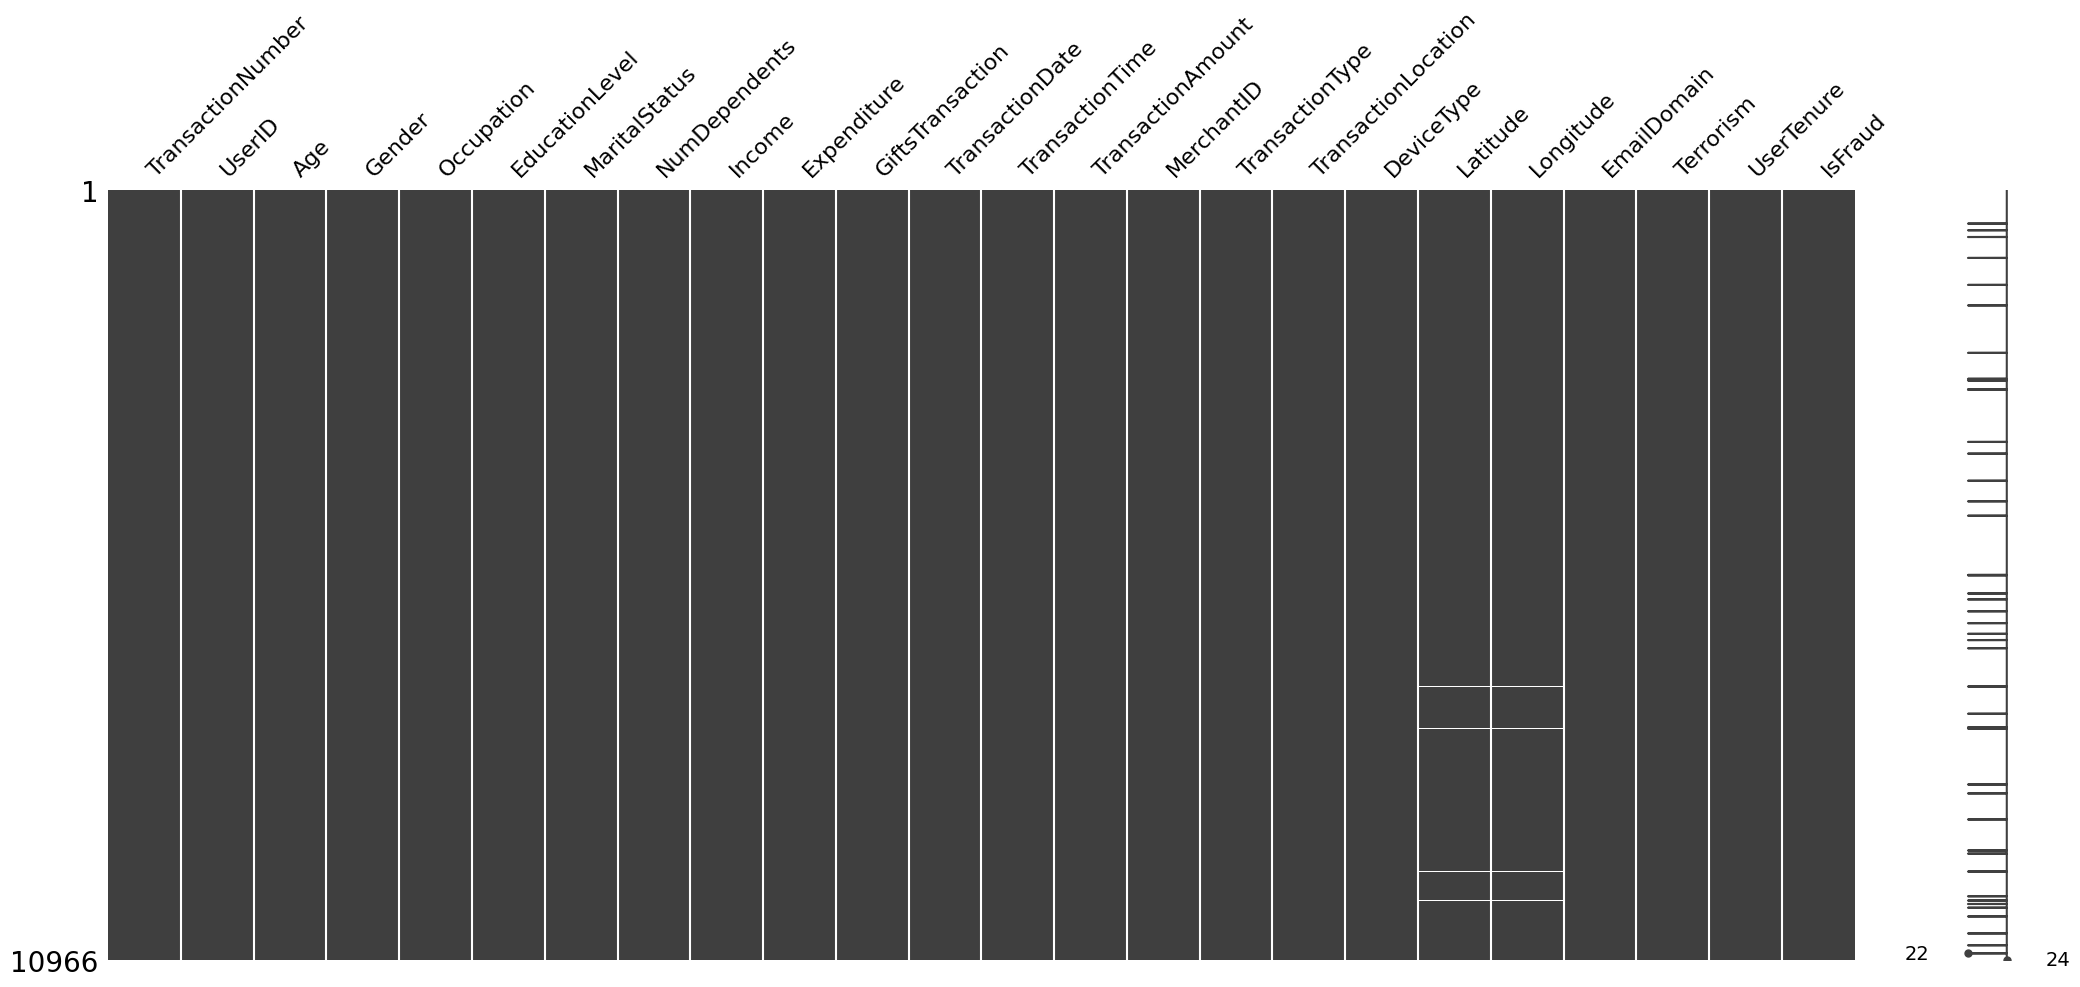

<Figure size 1500x900 with 0 Axes>

In [307]:
# Missing data
msno.matrix(train_df)
plt.figure(figsize = (15,9))
plt.show()

In [308]:
def get_numerical_summary(df):
    total = df.shape[0]
    missing_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
    missing_percent = {}
    for col in missing_columns:
        null_count = df[col].isnull().sum()
        per = (null_count/total) * 100
        missing_percent[col] = per
        print("{} : {} ({}%)".format(col, null_count, round(per, 3)))
    return missing_percent

missing_percent = get_numerical_summary(train_df)
missing_percent

Latitude : 43 (0.392%)
Longitude : 43 (0.392%)


{'Latitude': np.float64(0.3921211015867226),
 'Longitude': np.float64(0.3921211015867226)}

In [309]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy='majority')
X_rus, y_rus = rus.fit_resample(train_df.drop(columns=['IsFraud']), train_df['IsFraud'])
train_df = pd.concat([X_rus, y_rus], axis=1)

In [310]:
# Age (does young adult cause more fraud?)
user_info = [
    "Age", 
    "Gender",
    "Terrorism",
    "Income",
    "MaritalStatus",
    "Occupation",
    "EducationLevel",
    "NumDependents",
    "GiftsTransaction" 
]
transaction_info = [
    "TransactionType", 
    "TransactionDate",
    "TransactionTime", 
    "TransactionAmount",
    "TransactionLocation" 
]
account_info = [
    "UserTenure",
    "Expenditure",
    "Latitude",
    "Longitude" 
]

## Cleaning

### Datetime

In [ ]:
def standard_time(time_str):
    try:
        if 'AM' in time_str or 'PM' in time_str:
            return pd.to_datetime(time_str, format='%I:%M:%S %p').strftime('%H:%M:%S')
        
        return pd.to_datetime(time_str, format='%H:%M:%S').strftime('%H:%M:%S')
    
    except (ValueError, TypeError):
        try:
            parts = time_str.split('/')
            corrected_time = f'{parts[0]}:{parts[1]}:{parts[2]}'
            return pd.to_datetime(corrected_time, format='%H:%M:%S').strftime('%H:%M:%S')
        except Exception:
            return 'NOPES'

train_df['TransactionTime'] = train_df['TransactionTime'].apply(standard_time)
print(train_df.isnull().sum())


#spliting month and date and adding weekday

train_df['TransactionDate'] = pd.to_datetime(train_df['TransactionDate'], dayfirst=True)

train_df['date'] = train_df['TransactionDate'].dt.day   
train_df['Month'] = train_df['TransactionDate'].dt.month  

train_df['weekday'] = train_df['TransactionDate'].dt.day_name()

### Drop irrelevant columns

In [311]:
# Keep only the columns above
train_df = train_df[user_info + transaction_info + account_info + ['IsFraud']]

### Clean currency data (4 columns)

In [312]:
import re
import pandas as pd

def get_currency_and_symbol(val):
    if 'AUD' in val or 'AU' in val:
        # create a feature for aud
        return re.sub(r'[^\d.]', '', val), 'AUD' 
    elif 'AED' in val:
        value = re.sub(r'[^\d.]', '', val)
        # convert AED to AUD
        return float(value) * 0.35, 'AED'
    elif '£' in val:
        value = re.sub(r'[^\d.]', '', val)
        # convert pounds to AUD
        return float(value) * 1.8, 'GBP'
    elif 'GBP' in val:
        value = re.sub(r'[^\d.]', '', val)
        # convert pounds to AUD
        return float(value) * 1.8, 'GBP'
    else:
        return "Unidentified", "Unknown" 


# Apply to Income
train_df['Income'], train_df['Income_Currency'] = zip(*train_df['Income'].apply(get_currency_and_symbol))
train_df['Income'] = pd.to_numeric(train_df['Income'], errors='coerce')  

# Apply to Expenditure
train_df['Expenditure'], train_df['Expenditure_Currency'] = zip(*train_df['Expenditure'].apply(get_currency_and_symbol))
train_df['Expenditure'] = pd.to_numeric(train_df['Expenditure'], errors='coerce')

# Apply to GiftsTransaction
train_df['GiftsTransaction'], train_df['GiftsTransaction_Currency'] = zip(*train_df['GiftsTransaction'].apply(get_currency_and_symbol))
train_df['GiftsTransaction'] = pd.to_numeric(train_df['GiftsTransaction'], errors='coerce')

# Apply to TransactionAmount
train_df['TransactionAmount'], train_df['TransactionAmount_Currency'] = zip(*train_df['TransactionAmount'].apply(get_currency_and_symbol))
train_df['TransactionAmount'] = pd.to_numeric(train_df['TransactionAmount'], errors='coerce') 

# Drop the original columns
# train_df.drop(columns=['Income', 'Expenditure', 'GiftsTransaction', 'TransactionAmount'], inplace=True)


In [313]:
# # Check if there's any missing values
# train_df['Income'].isnull().sum()
# train_df[train_df['Income'] == 'Unidentified']
# # expenditure
# train_df['Expenditure'].isnull().sum()
# train_df[train_df['Expenditure'] == 'Unidentified']
# # giftsTransaction
# train_df['GiftsTransaction'].isnull().sum()
# train_df[train_df['GiftsTransaction'] == 'Unidentified']
# # TransactionAmountggV
# train_df['TransactionAmount'].isnull().sum()
# train_df[train_df['TransactionAmount'] == 'Unidentified']

In [314]:
# Convert categorical data to numerical data through One Hot Encoding
user_df = pd.get_dummies(train_df[user_info])
transaction_df = pd.get_dummies(train_df[transaction_info])
account_df = pd.get_dummies(train_df[account_info])
# Append IsFraud to the all dfs
user_df['IsFraud'] = train_df['IsFraud']
transaction_df['IsFraud'] = train_df['IsFraud']
account_df['IsFraud'] = train_df['IsFraud']

In [315]:
# Calculate correlations once for each DataFrame
user_corr = user_df.corrwith(user_df['IsFraud'])
transaction_corr = transaction_df.corrwith(transaction_df['IsFraud'])
account_corr = account_df.corrwith(account_df['IsFraud'])

# Sort the correlations in descending order
user_corr = user_corr.sort_values(ascending=False)
transaction_corr = transaction_corr.sort_values(ascending=False)
account_corr = account_corr.sort_values(ascending=False)


In [316]:
user_corr.head(10)

IsFraud                   1.000000
MaritalStatus_Divorced    0.037384
EducationLevel_PhD        0.029194
Occupation_Unemployed     0.022104
MaritalStatus_Widowed     0.019145
Terrorism                 0.017122
Income                    0.015359
GiftsTransaction          0.009925
Gender_he                 0.008173
Gender_fem                0.006476
dtype: float64

In [317]:
transaction_corr.head(10)

IsFraud                         1.000000
TransactionType_Withdrawal      0.525823
TransactionTime_00:00:00        0.136476
TransactionAmount               0.107883
TransactionLocation_Brisbane    0.053009
TransactionTime_00/00/00        0.051542
TransactionTime_12:00:00 AM     0.040976
TransactionLocation_Perth       0.040400
TransactionLocation_Adelaide    0.038875
TransactionLocation_Hobart      0.035886
dtype: float64

In [318]:
account_corr

IsFraud        1.000000
Longitude      0.015422
UserTenure     0.005667
Expenditure    0.001563
Latitude      -0.000920
dtype: float64

### Categorical columns

In [319]:
def binary_encode(df, column, positive_value):
    df = df.copy()
    df[column] = df[column].apply(lambda x: 1 if x == positive_value else 0)
    return df

def ordinal_encode(df, column, ordering):
    df = df.copy()
    df[column] = df[column].apply(lambda x: ordering.index(x))
    return df


In [320]:
gender_mapping = {
    'fem': 'Female',
    'Female': 'Female',
    'she': 'Female',
    'woman': 'Female',
    'he': 'Male',
    'man': 'Male',
    'Male': 'Male',
    'isnotfemale': 'Male',
    'isnotmale': 'Female',
}

train_df['Gender'] =train_df['Gender'].map(gender_mapping).fillna('Other')

In [321]:
occupation_order = [
    "Student",
    "Unemployed",
   "Retired", 
    "Professional",
]
education_order = [
    "High School","Bachelor","Master","PhD"
]

In [322]:
train_df = binary_encode(train_df, "Gender", "Male")
train_df = ordinal_encode(train_df, "Occupation", occupation_order)
train_df = ordinal_encode(train_df, "EducationLevel", education_order)
train_df = binary_encode(train_df, "Terrorism", True)

In [323]:
# One hot encoding for the rest
train_df = pd.get_dummies(train_df, columns=["MaritalStatus", "TransactionType", "TransactionLocation"])

In [324]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7990 entries, 7421 to 10965
Data columns (total 62 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                7990 non-null   int64  
 1   Gender                             7990 non-null   int64  
 2   Terrorism                          7990 non-null   int64  
 3   Income                             7990 non-null   float64
 4   Occupation                         7990 non-null   int64  
 5   EducationLevel                     7990 non-null   int64  
 6   NumDependents                      7990 non-null   int64  
 7   GiftsTransaction                   7990 non-null   float64
 8   TransactionDate                    7990 non-null   object 
 9   TransactionTime                    7990 non-null   object 
 10  TransactionAmount                  7990 non-null   float64
 11  UserTenure                         7990 non-null   int64 

## EDA

In [224]:
# make default plot smaller
plt.rcParams['figure.figsize'] = [12, 3]

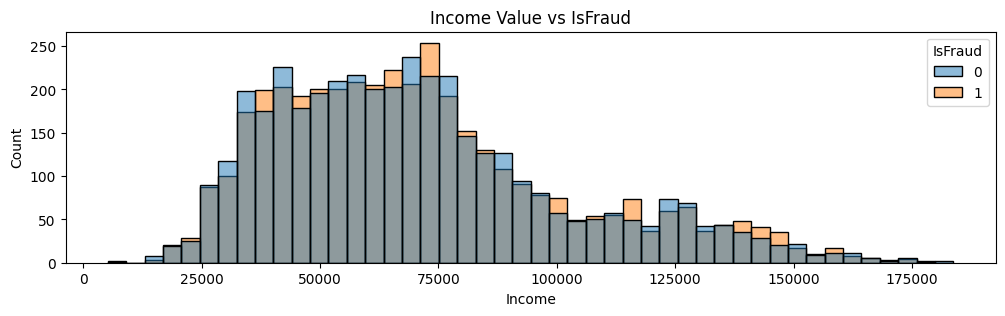

In [225]:
# Plot the income against the isFraud, histogram
sns.histplot(x='Income', hue='IsFraud', data=train_df)
plt.title('Income Value vs IsFraud')
plt.show()

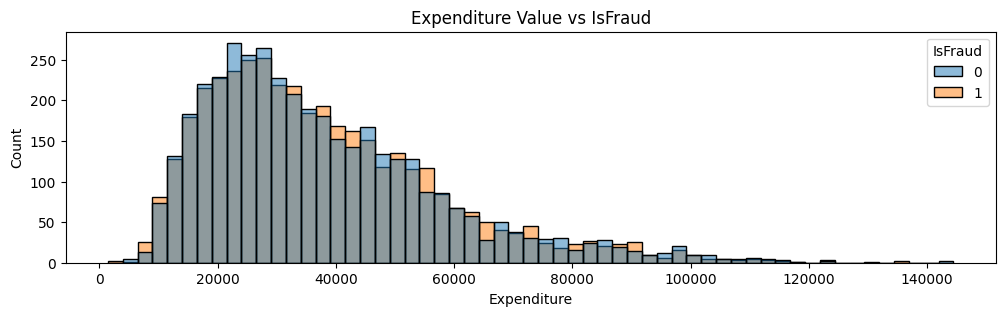

In [226]:
# Plot expenditure value against the isFraud, histogram
sns.histplot(x='Expenditure', hue='IsFraud', data=train_df)
plt.title('Expenditure Value vs IsFraud')
plt.show()

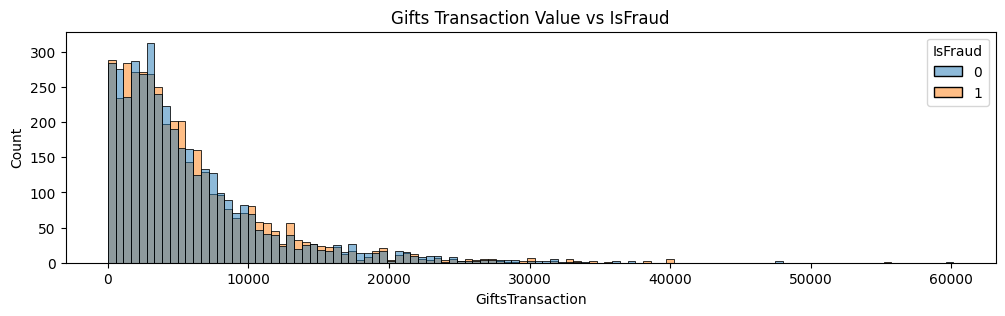

In [227]:
# Plot gifts transaction value against the isFraud, histogram
sns.histplot(x='GiftsTransaction', hue='IsFraud', data=train_df)
plt.title('Gifts Transaction Value vs IsFraud')
plt.show()

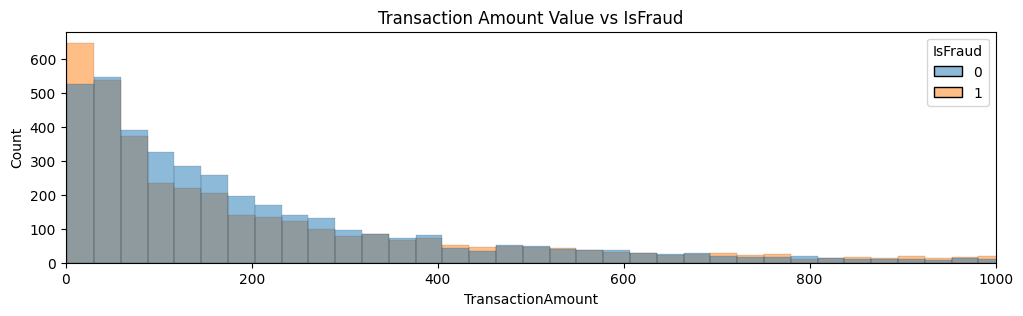

In [228]:
# Plot transaction amount value against the isFraud, histogram, zoom into the range of 0 to 1000
sns.histplot(x='TransactionAmount', hue='IsFraud', data=train_df)
plt.xlim(0, 1000)
plt.title('Transaction Amount Value vs IsFraud')
plt.show()

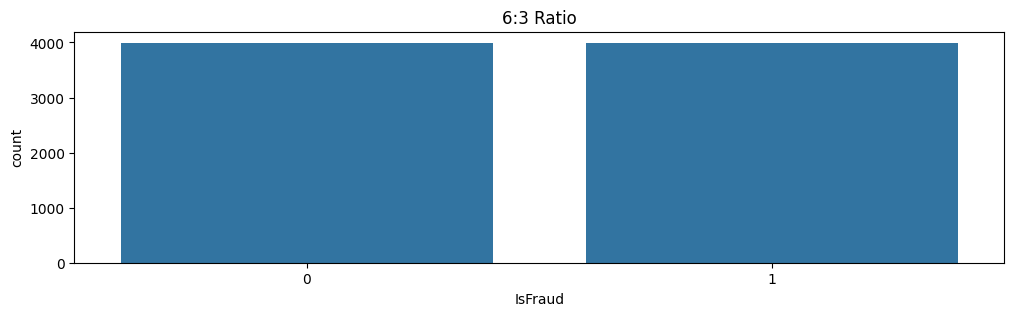

In [229]:
# Check the number of 0 and 1 in the IsFraud column, gimme ratio
train_df['IsFraud'].value_counts(normalize=True)
# Barplot it
sns.countplot(x='IsFraud', data=train_df)
plt.title('6:3 Ratio')
plt.show()

In [230]:
# Check correlation between the features: Income, Expenditure, GiftsTransaction, TransactionAmount, and IsFraud
train_df[['Income', 'Expenditure', 'GiftsTransaction', 'TransactionAmount', 'IsFraud']].corr()

,Income,Expenditure,GiftsTransaction,TransactionAmount,IsFraud
Income,1.000000,0.825539,0.444210,0.008946,0.015123
Expenditure,0.825539,1.000000,0.358977,0.004653,0.005141
GiftsTransaction,0.444210,0.358977,1.000000,-0.005178,0.005931
TransactionAmount,0.008946,0.004653,-0.005178,1.000000,0.102440
IsFraud,0.015123,0.005141,0.005931,0.102440,1.000000


=> Transaction amount, expenditure, and gift transaction values have little correlation with IsFraud

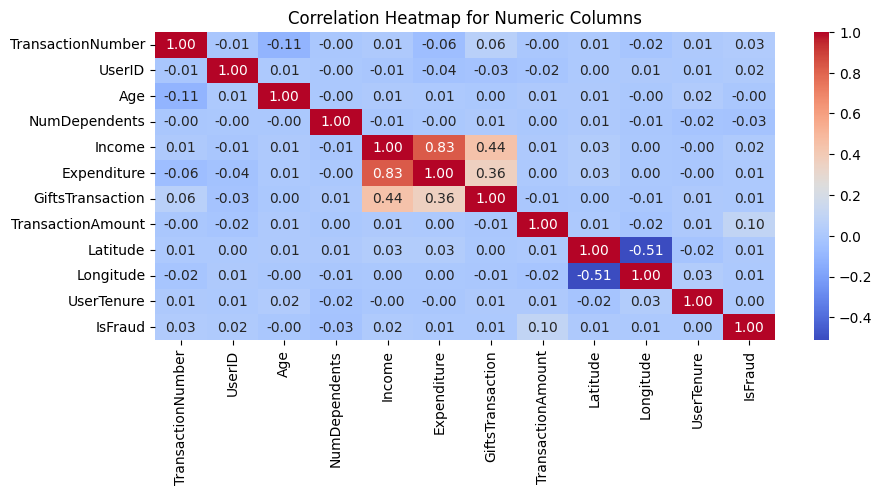

In [231]:
# Select only the numeric columns
numeric_data = train_df.select_dtypes(include=['number'])

# Calculate the correlation matrix for numeric columns
correlation_matrix = numeric_data.corr()

# Create a heatmap
plt.figure(figsize=(10, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap for Numeric Columns')

plt.show()